Euler solutions:
Lower right anomaly location: [-1072.04297339  -830.29615323  1428.85976886]
Upper left anomaly location: [1018.12838822 1576.71821498 1039.07466633]
Centers of the model spheres:
[-1000 -1000  1500]
[1000 1500 1000]


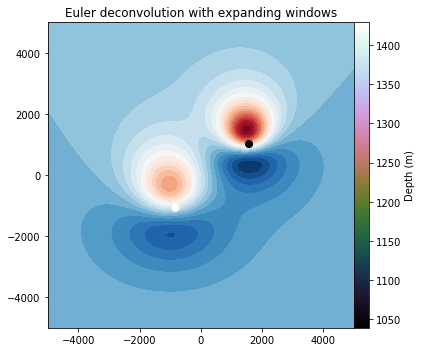

In [14]:
"""
基于扩展窗的欧拉反卷积算法

欧拉反卷积的常用方法是基于滑动窗口：但由于每个窗口是在整个区域仅运行一次解卷积会产生很多虚假的解决方案。
并且基于滑动窗口的反卷积方法不能出给指定的源的个数。所以发展了基于扩展窗的欧拉反卷积算法。
其基本思想是：从一个选点的中心点扩展许多窗口进行反卷积。然后只选择其中一个解决方案（最小误差方案）作为最终估计。
这种方法不仅可以提供单一解决方案，还可以通过可以针对每个异常选择不同的扩展中心实现对多个异常的解释。

扩展窗口方案实现于：geoist.euler_expanding_window.ipynb。
"""
from geoist.pfm import sphere, pftrans, euler, giutils
from geoist import gridder
from geoist.inversion import geometry
from geoist.vis import giplt
import matplotlib.pyplot as plt
import numpy as np
##合成磁数据测试欧拉反卷积
# 磁倾角，磁偏角
inc, dec = -45, 0
# 制作仅包含感应磁化的两个球体模型
model = [
    geometry.Sphere(x=-1000, y=-1000, z=1500, radius=1000,
                  props={'magnetization': giutils.ang2vec(2, inc, dec)}),
    geometry.Sphere(x=1000, y=1500, z=1000, radius=1000,
                  props={'magnetization': giutils.ang2vec(1, inc, dec)})]
# 从模型中生成磁数据
shape = (100, 100)
area = [-5000, 5000, -5000, 5000]
x, y, z = gridder.regular(area, shape, z=-150)
data = sphere.tf(x, y, z, model, inc, dec)

# 一阶导数
xderiv = pftrans.derivx(x, y, data, shape)
yderiv = pftrans.derivy(x, y, data, shape)
zderiv = pftrans.derivz(x, y, data, shape)

#通过扩展窗方法实现欧拉反卷积 
#给出2个解决方案，每一个扩展窗都靠近异常
#stutural_index=3表明异常源为球体
'''
    ===================================== ======== =========
    源类型                                 SI (磁) SI (重力)
    ===================================== ======== =========
    Point, sphere                            3         2
    Line, cylinder, thin bed fault           2         1
    Thin sheet edge, thin sill, thin dyke    1         0
    ===================================== ======== =========
'''

#制作求解器并使用fit()函数来获取右下角异常的估计值
print("Euler solutions:")
sol1 = euler.EulerDeconvEW(x, y, z, data, xderiv, yderiv, zderiv,
                           structural_index=3, center=(-2000, -2000),
                           sizes=np.linspace(300, 7000, 20))
sol1.fit()
print("Lower right anomaly location:", sol1.estimate_)

#制作求解器并使用fit()函数来获取左上角异常的估计值
sol2 = euler.EulerDeconvEW(x, y, z, data, xderiv, yderiv, zderiv,
                           structural_index=3, center=(2000, 2000),
                           sizes=np.linspace(300, 7000, 20))
sol2.fit()
print("Upper left anomaly location:", sol2.estimate_)

print("Centers of the model spheres:")
print(model[0].center)
print(model[1].center)

# 在磁数据上绘制异常估计值结果
# 异常源的中心的真正深度为1500 m 和1000 m。
plt.figure(figsize=(6, 5))
plt.title('Euler deconvolution with expanding windows')
plt.contourf(y.reshape(shape), x.reshape(shape), data.reshape(shape), 30,
             cmap="RdBu_r")
plt.scatter([sol1.estimate_[1], sol2.estimate_[1]],
            [sol1.estimate_[0], sol2.estimate_[0]],
            c=[sol1.estimate_[2], sol2.estimate_[2]],
            s=50, cmap='cubehelix')
plt.colorbar(pad=0).set_label('Depth (m)')
plt.xlim(area[2:])
plt.ylim(area[:2])
plt.tight_layout()
plt.show()